In [119]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import operator
from sklearn.naive_bayes import GaussianNB

## Challengue
Now that you've spent some time tinkering with an example Naive Bayes Classifier, it's time to build your own.

We've mentioned that Naive Bayes is particularly good for text classification problems. Before we made a spam filter. Now we'll perform a sentiment analysis, classifying whether feedback left on a website is either positive or negative.

Again the UCI Machine Learning database has a nice labeled dataset of sentiment labelled sentences for us to use. This dataset was created for the paper From Group to Individual Labels using Deep Features, Kotzias et. al., KDD 2015.

Pick one of the company data files and build your own classifier. When you're satisfied with its performance (at this point just using the accuracy measure shown in the example), test it on one of the other datasets to see how well these kinds of classifiers translate from one context to another.

Include your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

First we import and merge all the data into one dataframe.

In [120]:
path = '/Users/Stephanie/desktop/thinkful/projects/3_bootcamp/' \
       'U2L2P7/sentiment labelled sentences/NAME_labelled.txt'

df = pd.DataFrame()
for company in ('yelp', 'imdb', 'amazon_cells'):
    company_df = pd.read_csv(path.replace('NAME', company), delimiter='\t', names=['Sentence', 'Sentiment'])
    company_df['Company'] = company
    print('{} length is {}'.format(company, len(company_df)))
    df = df.append(company_df)
    
    
df.Sentence = df.Sentence.str.lower()

df.head()


yelp length is 1000
imdb length is 748
amazon_cells length is 1000


,Sentence,Sentiment,Company
0,wow... loved this place.,1,yelp
1,crust is not good.,0,yelp
2,not tasty and the texture was just nasty.,0,yelp
3,stopped by during the late may bank holiday of...,1,yelp
4,the selection on the menu was great and so wer...,1,yelp


we're going to train on the yelp df and test on the amazon and also imdb dataframes

In [121]:
yelp = df[df['Company'] == 'yelp'][['Sentence', 'Sentiment']]
amazon_cells = df[df['Company'] == 'amazon_cells'][['Sentence', 'Sentiment']]

We want to find some good keywords both for positive and negative sentences. So we're going to select the positive sentences and see what words are more common. We'll get from that list any positive adjetives that we see are commonly used. We have to keep in mind that the words so be as general as possible so that our model can be apply to other industries datasets and work well. (so for example avoid using 'delicious' but 'great' instead')

We'll do the same thing with negative sentences

In [122]:
remove = ['and', 'the', 'all', 'for', 'was', 'you']

positive = yelp[yelp['Sentiment'] == 1]

p_alpnumeric = positive.copy()
p_alpnumeric.Sentence = p_alpnumeric.Sentence.str.replace('[^a-zA-Z\d\s:]', '')
for word in remove:
    p_alpnumeric.Sentence = p_alpnumeric.Sentence.str.replace(word, '')

p_words = []
for sentence in p_alpnumeric.Sentence:
    words = sentence.split(' ')
    p_words = p_words + words

p_words = pd.Series(p_words)

p_words = p_words[p_words.str.len() >= 3] #remove prepositions, etc.
    
p_words_count = dict(Counter(p_words))

top30_p_words = dict(sorted(p_words_count.items(), key=operator.itemgetter(1), reverse=True)[:30])

we're pursposelly ommitting like, really and very which multiply the sentiment but can

In [123]:
# would do a function if I had more time instead of dumping the same code again...
negative = yelp[yelp['Sentiment'] == 0]

n_alpnumeric = negative.copy()
n_alpnumeric.Sentence = n_alpnumeric.Sentence.str.replace('[^a-zA-Z\d\s:]', '')
n_alpnumeric.Sentence = n_alpnumeric.Sentence.str.lower()
for word in remove:
    n_alpnumeric.Sentence = n_alpnumeric.Sentence.str.replace(word, '')

n_words = []
for sentence in n_alpnumeric.Sentence:
    words = sentence.split(' ')
    n_words = n_words + words

n_words = pd.Series(n_words)

n_words = n_words[n_words.str.len() >= 3] #remove most prepositions, etc.
    
n_words_count = dict(Counter(n_words))

top30_n_words = dict(sorted(n_words_count.items(), key=operator.itemgetter(1), reverse=True)[:30])

In [124]:
good = pd.Series(top30_p_words, index=top30_p_words.keys())
bad = pd.Series(top30_n_words, index=top30_n_words.keys())

words_df = pd.concat([good, bad], axis=1)
words_df.columns = ['positive', 'negative']
words_df

,positive,negative
again,NaN,16.0
also,18.0,NaN
amazing,21.0,NaN
are,36.0,27.0
back,23.0,38.0
bad,NaN,18.0
best,22.0,NaN
but,20.0,42.0
delicious,23.0,NaN
dont,NaN,25.0


Now, we want to add as positive keywords those that are common in the positive sentences and not in the negative, and same for the negative keywords. They also have to be general words and not just specific to the food industry.

Finally we have some words that could go either way depending on how they're combined (e.g. like as _'I like'_ and _'I don't like'_). If an amplifier is found in the sentence it will increase the existing sentiment (positive or negative)

In [125]:
pos_kwords = ['amazing', 'best', 'friendly', 'nice', 'love']

neg_kwords = ["don't", 'ever', 'never', 'not', 'bad', 'again', 'no']


kwords = pos_kwords + neg_kwords

In [126]:
for key in kwords:
    yelp.Sentence = ' ' + yelp.Sentence.astype(str) + ' '
    yelp[str(key)] = yelp.Sentence.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

Let's see how many of the 1000 entries have any of the positive or negative keywords. We won't include the amplifiers as they increase the sentiment but work in combination with a negative or positive keyword

In [127]:
len(yelp[yelp.loc[:,'amazing':'no'].any(1)])

265

Let's check if we have a strong correlation between any of the keywords

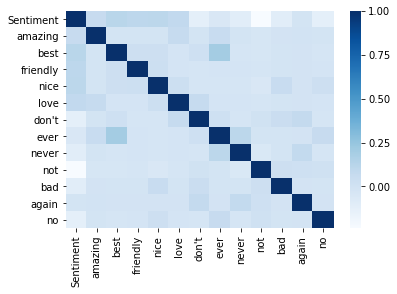

In [128]:
sns.heatmap(yelp.corr(), cmap="Blues")

It looks good.

### Predict against the same df (yelp)

In [129]:
data = yelp[kwords]
target = yelp['Sentiment']

gnb = GaussianNB()
gnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = gnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 370


### Predict against another df (amazon)

In [130]:
for key in kwords:
    amazon_cells.Sentence = ' ' + amazon_cells.Sentence.astype(str) + ' '
    amazon_cells[str(key)] = amazon_cells.Sentence.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

data_amazon = amazon_cells[kwords]
target_amazon = amazon_cells['Sentiment']

# Classify, storing the result in a new variable.
y_pred = gnb.predict(data_amazon)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_amazon.shape[0],
    (target_amazon != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 379
